In [1]:
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os
from astropy.io import fits
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
source_name='NGC 2110'
ra=88.047400
dec=-7.456247
radius=10.
Tstart='2003-03-15T00:00:00'
Tstop='2015-12-26T00:00:00'
host='www.astro.unige.ch/cdci/astrooda'
rebin=5 # minimal significance in energy bin, for spectral plotting

In [5]:
token=input() # token for restricted access server
cookies=dict(_oauth2_proxy=token)

In [6]:
#disp=DispatcherAPI(host=host+'/dispatch-data',instrument='mock',cookies=cookies,protocol='https')
disp=DispatcherAPI(host='www.astro.unige.ch/cdci/astrooda/dispatch-data',instrument='mock',protocol='https')

In [8]:
import requests
url="https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/"
def queryxtime(**args):
    params=Tstart+'/'+Tstop+'?&ra='+str(ra)+'&dec='+str(dec)+'&radius='+str(radius)+'&min_good_isgri=1000&index_version=20190904083708'
    print(url+params)
    return requests.get(url+params,cookies=cookies).json()

In [9]:
#if token!='':
scwlist=queryxtime()
m=len(scwlist)
pointings=[]
for i in range(m):
    if scwlist[i][-2:]=='10':
        pointings.append(scwlist[i]+'.001')
#else:
#    pointings=np.genfromtxt('scws_3C279_isgri_10deg.txt', dtype='str')
m=int(len(pointings)/50.)
print(m)

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/2003-03-15T00:00:00/2015-12-26T00:00:00?&ra=88.0474&dec=-7.456247&radius=10.0&min_good_isgri=1000&index_version=20190904083708
17


In [10]:
scw_lists=[]
for i in range(m):
    count=0
    scw_string=''
    while(count<50):
        scw_string=scw_string+str(pointings[50*i+count])+','
        count+=1
    scw_lists.append(scw_string[:-1])


In [11]:
data=disp.get_product(instrument='isgri',
                      product='isgri_image',
                      scw_list=scw_lists[0],
                      E1_keV=20.0,
                      E2_keV=40.0,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=3.5,
                      product_type='Real')

048300050010.001,048300060010.001,048300070010.001,048300080010.001,048300160010.001,048300370010.001,048700080010.001,048700090010.001,048700100010.001,048700170010.001,048700180010.001,048700190010.001,048700580010.001,048700590010.001,048700600010.001,053000540010.001,053000550010.001,053000560010.001,053000630010.001,053000640010.001,053000660010.001,053200050010.001,053200060010.001,053200150010.001,053200360010.001,053200440010.001,053200450010.001,053200460010.001,053200470010.001,053200540010.001,053200550010.001,053200560010.001,053800040010.001,053800250010.001,053800330010.001,053800340010.001,053800350010.001,053800360010.001,053800430010.001,053800440010.001,053800450010.001,053800460010.001,053800540010.001,054300260010.001,054300340010.001,054300350010.001,054300360010.001,054300370010.001,054300430010.001,054300440010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 048300050010.001,048300060010.

In [12]:
data.dispatcher_catalog_1.table



meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str18,float64,float64,float64,int64,int64,int64,float64
3,Ark 120,9.783936500549316,79.03569030761719,-0.1271200329065323,-32768,2,0,0.0002800000074785203
4,H 0614+091,20.382593154907227,94.28584289550781,9.143746376037598,-32768,2,0,0.0002800000074785203
14,NGC 2110,16.466463088989258,88.06703186035156,-7.4683003425598145,-32768,2,0,0.0002800000074785203
16,SWIFT J0453.4+0404,4.379733085632324,73.35724639892578,4.0615553855896,-32768,2,0,0.00013888889225199819


In [13]:
FLAG=0
torm=[]
for ID,n in enumerate(data.dispatcher_catalog_1.table['src_names']):
    if(n=='NEW_1'):
        torm.append(ID)
    if(n==source_name):
        FLAG=1
data.dispatcher_catalog_1.table.remove_rows(torm)

nrows=len(data.dispatcher_catalog_1.table['src_names'])
print(nrows)
print(FLAG)

4
1


In [14]:
if FLAG==0:
    data.dispatcher_catalog_1.table.add_row()
    data.dispatcher_catalog_1.table['src_names'][nrows]='3C 279'
    data.dispatcher_catalog_1.table['ra'][nrows]=ra
    data.dispatcher_catalog_1.table['dec'][nrows]=dec
    data.dispatcher_catalog_1.table['ISGRI_FLAG'][nrows]=2

data.dispatcher_catalog_1.table


meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str18,float64,float64,float64,int64,int64,int64,float64
3,Ark 120,9.783936500549316,79.03569030761719,-0.1271200329065323,-32768,2,0,0.0002800000074785203
4,H 0614+091,20.382593154907227,94.28584289550781,9.143746376037598,-32768,2,0,0.0002800000074785203
14,NGC 2110,16.466463088989258,88.06703186035156,-7.4683003425598145,-32768,2,0,0.0002800000074785203
16,SWIFT J0453.4+0404,4.379733085632324,73.35724639892578,4.0615553855896,-32768,2,0,0.00013888889225199819


In [15]:
api_cat=data.dispatcher_catalog_1.get_api_dictionary()

In [60]:
spectrum_results=[]
for i in range(len(scw_lists)):
    print(i)
    data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        scw_list=scw_lists[i],
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat)
    spectrum_results.append(data)

0
048300050010.001,048300060010.001,048300070010.001,048300080010.001,048300160010.001,048300370010.001,048700080010.001,048700090010.001,048700100010.001,048700170010.001,048700180010.001,048700190010.001,048700580010.001,048700590010.001,048700600010.001,053000540010.001,053000550010.001,053000560010.001,053000630010.001,053000640010.001,053000660010.001,053200050010.001,053200060010.001,053200150010.001,053200360010.001,053200440010.001,053200450010.001,053200460010.001,053200470010.001,053200540010.001,053200550010.001,053200560010.001,053800040010.001,053800250010.001,053800330010.001,053800340010.001,053800350010.001,053800360010.001,053800430010.001,053800440010.001,053800450010.001,053800460010.001,053800540010.001,054300260010.001,054300340010.001,054300350010.001,054300360010.001,054300370010.001,054300430010.001,054300440010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 048300050010.001,04830006001



query done succesfully!
3
071800340010.001,071800350010.001,071800360010.001,071800370010.001,071800380010.001,071800390010.001,071800400010.001,071800410010.001,071800420010.001,071800430010.001,071800440010.001,071800450010.001,071800460010.001,071800470010.001,071800480010.001,071800490010.001,071800500010.001,071800510010.001,071800520010.001,071800530010.001,071800540010.001,071800550010.001,071800560010.001,071800570010.001,071800580010.001,071900120010.001,071900130010.001,071900140010.001,071900150010.001,071900160010.001,071900170010.001,071900180010.001,071900190010.001,071900200010.001,071900210010.001,071900220010.001,071900230010.001,071900240010.001,071900250010.001,071900260010.001,071900270010.001,071900280010.001,071900290010.001,071900300010.001,071900310010.001,071900320010.001,071900330010.001,071900340010.001,085400180010.001,085400190010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 07



query done succesfully!
6
097300500010.001,097300890010.001,097300900010.001,097300910010.001,097300920010.001,097300930010.001,097300940010.001,097300950010.001,097300960010.001,097300970010.001,097300980010.001,097400030010.001,097400040010.001,097400050010.001,097400060010.001,097400070010.001,097400080010.001,097400090010.001,097400100010.001,097400110010.001,097400120010.001,097400510010.001,097400520010.001,097400530010.001,097400540010.001,097400550010.001,097400560010.001,097400570010.001,097400580010.001,097400590010.001,097400600010.001,097500230010.001,097500240010.001,097500250010.001,097500260010.001,097500270010.001,097500280010.001,097500290010.001,097500300010.001,097500310010.001,097500320010.001,097500370010.001,097500380010.001,097500390010.001,097500400010.001,097500410010.001,097500420010.001,097500430010.001,097500440010.001,097500450010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 09



query done succesfully!
9
127000780010.001,127000790010.001,127000800010.001,127500680010.001,127500760010.001,127500770010.001,127500780010.001,127500790010.001,127500860010.001,127500870010.001,127500880010.001,127800630010.001,127800640010.001,127800650010.001,127800660010.001,127800830010.001,127800840010.001,127800850010.001,127800860010.001,127800870010.001,127800880010.001,127800890010.001,127800910010.001,127800920010.001,127900070010.001,127900280010.001,127900370010.001,127900380010.001,128100060010.001,128100070010.001,128100080010.001,128100090010.001,128100100010.001,128100110010.001,128100120010.001,128100130010.001,128100150010.001,128100160010.001,128100170010.001,128100180010.001,128100190010.001,128100200010.001,128100220010.001,128100290010.001,128100300010.001,128100310010.001,131700340010.001,131700430010.001,132600040010.001,132600050010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 12



query done succesfully!
12
144400320010.001,144400330010.001,144400340010.001,144400370010.001,144400380010.001,144400390010.001,144400400010.001,144400410010.001,144400420010.001,144400430010.001,144400480010.001,144400490010.001,144400500010.001,144400510010.001,144400520010.001,144500050010.001,144500060010.001,144500070010.001,144500080010.001,144500090010.001,144500100010.001,144500140010.001,144500150010.001,144500160010.001,144500170010.001,144500180010.001,144500190010.001,144500200010.001,144500210010.001,144500250010.001,144500260010.001,144500270010.001,144500280010.001,144500290010.001,144500300010.001,144500310010.001,144500340010.001,144500350010.001,144500360010.001,144500370010.001,144500380010.001,144500390010.001,144500400010.001,144500460010.001,144500470010.001,144500480010.001,144500490010.001,144500500010.001,144500510010.001,144500520010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 1



query done succesfully!
15
146300590010.001,146300600010.001,150000470010.001,150300320010.001,150300330010.001,150300420010.001,150400020010.001,150400030010.001,150400070010.001,150400080010.001,150400090010.001,150400100010.001,150400110010.001,150400120010.001,150400170010.001,150400180010.001,150400190010.001,150400200010.001,150400210010.001,150400220010.001,150400280010.001,150400290010.001,150400300010.001,150400310010.001,150400370010.001,150400380010.001,150400390010.001,150400400010.001,150400410010.001,150400420010.001,150400430010.001,150400460010.001,150500020010.001,150500030010.001,150500040010.001,150500050010.001,150500060010.001,150500090010.001,150500100010.001,150500110010.001,150500120010.001,150500130010.001,150500140010.001,150500150010.001,150500160010.001,150500190010.001,150500200010.001,150500210010.001,150500220010.001,150500230010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 1

In [61]:
for ID,s in enumerate(data._p_list):
    if (s.meta_data['src_name']==source_name):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)

                                             

0 1 2


In [77]:
d=spectrum_results[0]
spec=d._p_list[ID_spec].data_unit[1].data
arf=d._p_list[ID_arf].data_unit[1].data
rmf=d._p_list[ID_rmf].data_unit[2].data
ch=spec['CHANNEL']
rate=spec['RATE']*0.
err=spec['STAT_ERR']*0.
syst=spec['SYS_ERR']*0.
rate.fill(0)
err.fill(0)
syst.fill(0)
qual=spec['QUALITY']
matrix=rmf['MATRIX']*0.
specresp=arf['SPECRESP']*0.
tot_expos=0.
corr_expos=np.zeros(len(rate))
print(len(rate))
for k in range(len(scw_lists)):
    d=spectrum_results[k]
    spec=d._p_list[ID_spec].data_unit[1].data
    arf=d._p_list[ID_arf].data_unit[1].data
    rmf=d._p_list[ID_rmf].data_unit[2].data
    expos=d._p_list[0].data_unit[1].header['EXPOSURE']
    tot_expos=tot_expos+expos
    print(k,expos)
    for j in range(len(rate)):
        if(spec['QUALITY'][j]==0):          
            rate[j]=rate[j]+spec['RATE'][j]/(spec['STAT_ERR'][j])**2
            err[j]=err[j]+1./(spec['STAT_ERR'][j])**2
            syst[j]=syst[j]+(spec['SYS_ERR'][j])**2*expos
            corr_expos[j]=corr_expos[j]+expos
    matrix=matrix+rmf['MATRIX']*expos
    specresp=specresp+arf['SPECRESP']*expos

for i in range(len(rate)):
    if err[i]>0.:
        rate[i]=rate[i]/err[i]
        err[i]=1./sqrt(err[i])
matrix=matrix/tot_expos
specresp=specresp/tot_expos
syst=sqrt(syst/(corr_expos+1.))
print('Total exposure:',tot_expos)

62
0 112004.5226494027
1 110147.9947506899
2 106118.0555422054
3 113143.3280120063
4 112157.294877559
5 96828.94506904678
6 62619.93384876712
7 61198.2749177427
8 112383.5909443086
9 121174.9784667263
10 120590.7816143036
11 114387.4684778941
12 120698.1348872847
13 115804.4614346624
14 112722.0648674613
15 112346.1922923422
16 113645.9905437856
Total exposure: 1817972.0131961885


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


In [78]:
print(rate)
print(err)

[ 0.         -0.0184415   0.11350693  0.11141226  0.18236405  0.15924783
  0.11004003  0.11305388  0.11163997  0.11624336  0.11350637  0.12077874
  0.12292462  0.10727138  0.19366525  0.16450435  0.15468137  0.13468814
  0.23542191  0.17834659  0.15725082  0.14714949  0.12542419  0.11715467
  0.11808373  0.09674025  0.08239804  0.05544152  0.04035207  0.04402985
  0.0416521   0.03413844  0.04991576  0.05872414  0.06949406  0.06688432
  0.05461214  0.04742418  0.04377751  0.0300382   0.02443377  0.01638404
  0.02294572  0.01736942  0.00719961  0.00035596  0.00925503  0.00811756
  0.00630949  0.00061435  0.00227821  0.0067001   0.00698778  0.00516335
 -0.00101977  0.00287471 -0.0011984   0.00208162  0.00343056 -0.01328348
 -0.00951325  0.00179989]
[0.         0.18677038 0.08756955 0.04556259 0.02900695 0.02078971
 0.01572994 0.01261658 0.01068923 0.00934913 0.0084212  0.00762582
 0.00702539 0.00650484 0.00819881 0.00709663 0.00622687 0.00564424
 0.00708114 0.00627969 0.00589001 0.0057010

In [79]:
d._p_list[ID_spec].data_unit[1].data['RATE']=rate
d._p_list[ID_spec].data_unit[1].data['STAT_ERR']=err
d._p_list[ID_rmf].data_unit[2].data['MATRIX']=matrix
d._p_list[ID_arf].data_unit[1].data['SPECRESP']=specresp

In [80]:
name=source_name.replace(" ", "")
specname=name+'_spectrum.fits'
arfname=name+'_arf.fits.gz'
rmfname=name+'_rmf.fits.gz'
data._p_list[ID_spec].write_fits_file(specname)
data._p_list[ID_arf].write_fits_file(arfname)
data._p_list[ID_rmf].write_fits_file(rmfname)

In [81]:
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', tot_expos)
hdul.close()


In [82]:
!./spectrum_fit.sh $name $rebin


		XSPEC version: 12.9.0n
	Build Date/Time: Tue Nov  8 18:03:34 2016

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data NGC2110_spectrum.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: NGC2110_spectrum.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.125e+00 +/- 2.194e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 1.818e+06 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response NGC2110_rmf.fits.gz
Response successfully loaded.
XSPEC12>arf NGC2110_arf.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:     6 channels ignored from  source number 1
XSPEC12>ignore **-20.
 

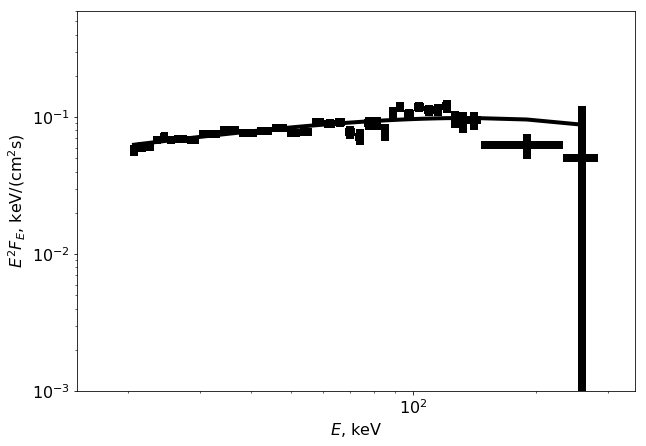

In [84]:
plt.figure(figsize=(10,7))

spectrum=np.genfromtxt(name+'_spectrum.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=1)
plt.plot(en,mo,color='black',linewidth=4)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-3,6.e-1)
plt.xlim(15,350)
plt.xlabel('$E$, keV',fontsize=16)
plt.ylabel('$E^2F_E$, keV/(cm$^2$s)',fontsize=16)
plt.savefig(name+'_spectrum.pdf',format='pdf',dpi=100)




In [86]:
spectrum_pdf=name+'_spectrum.pdf'